In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
DATA_PATH = Path() / "../../data/raw"
DATA_PATH.mkdir(parents=True,exist_ok=True)

def load_csv(filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    return pd.read_csv(csv_path,encoding=encoding)

data = load_csv("Q1_2015.csv", encoding='ISO-8859-1')

In [2]:
# data = pd.read_csv("../data/DataCoSupplyChainDataset.csv",encoding='ISO-8859-1')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Type                           15233 non-null  object 
 1   Days for shipping (real)       15233 non-null  int64  
 2   Days for shipment (scheduled)  15233 non-null  int64  
 3   Benefit per order              15233 non-null  float64
 4   Sales per customer             15233 non-null  float64
 5   Delivery Status                15233 non-null  object 
 6   Late_delivery_risk             15233 non-null  int64  
 7   Category Id                    15233 non-null  int64  
 8   Category Name                  15233 non-null  object 
 9   Customer City                  15233 non-null  object 
 10  Customer Country               15233 non-null  object 
 11  Customer Email                 15233 non-null  object 
 12  Customer Fname                 15233 non-null 

In [4]:
# data = supplyChain.iloc[:2000,:]
# data

In [5]:
data['order date']= pd.to_datetime(data['order date (DateOrders)'])
data['shipping date']= pd.to_datetime(data['shipping date (DateOrders)'])
data['order year']=data['order date'].dt.year
data['order month']=data['order date'].dt.month
data['order day']=data['order date'].dt.day
data['order hour']=data['order date'].dt.hour
data['order minute']=data['order date'].dt.minute

data['shipping year']=data['shipping date'].dt.year
data['shipping month']=data['shipping date'].dt.month
data['shipping day']=data['shipping date'].dt.day
data['shipping hour']=data['shipping date'].dt.hour
data['shipping minute']=data['shipping date'].dt.minute

In [6]:
data_n=data.loc[:,['Type','Days for shipment (scheduled)','order year','order month','order day','order hour','order minute','Benefit per order','Category Name','Latitude','Longitude','Customer Segment','Department Name','Market','Order City','Order Country','Order Item Discount','Order Item Product Price','Order Item Quantity','Order Item Total','Order State','Product Name','shipping year','shipping month','shipping day','shipping hour','shipping minute','Shipping Mode','Late_delivery_risk','Order Status']]
data_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Type                           15233 non-null  object 
 1   Days for shipment (scheduled)  15233 non-null  int64  
 2   order year                     15233 non-null  int64  
 3   order month                    15233 non-null  int64  
 4   order day                      15233 non-null  int64  
 5   order hour                     15233 non-null  int64  
 6   order minute                   15233 non-null  int64  
 7   Benefit per order              15233 non-null  float64
 8   Category Name                  15233 non-null  object 
 9   Latitude                       15233 non-null  float64
 10  Longitude                      15233 non-null  float64
 11  Customer Segment               15233 non-null  object 
 12  Department Name                15233 non-null 

In [7]:
data_n['Order Status'].value_counts()

COMPLETE           4874
PENDING_PAYMENT    3254
PROCESSING         1938
PENDING            1833
CLOSED             1728
ON_HOLD             762
SUSPECTED_FRAUD     355
CANCELED            326
PAYMENT_REVIEW      163
Name: Order Status, dtype: int64

In [8]:
data_n['Order Status']= [0 if i!='SUSPECTED_FRAUD' else 1 for i in data_n['Order Status']]

In [9]:
data_n['Order Status'].value_counts()

0    14878
1      355
Name: Order Status, dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder

enc=LabelEncoder()
for i in data_n.columns:
    if data_n[i].dtype=='object':
        data_n[i]=enc.fit_transform(data_n[i])

In [11]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Type                           15233 non-null  int64  
 1   Days for shipment (scheduled)  15233 non-null  int64  
 2   order year                     15233 non-null  int64  
 3   order month                    15233 non-null  int64  
 4   order day                      15233 non-null  int64  
 5   order hour                     15233 non-null  int64  
 6   order minute                   15233 non-null  int64  
 7   Benefit per order              15233 non-null  float64
 8   Category Name                  15233 non-null  int64  
 9   Latitude                       15233 non-null  float64
 10  Longitude                      15233 non-null  float64
 11  Customer Segment               15233 non-null  int64  
 12  Department Name                15233 non-null 

In [12]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

y=data_n['Order Status']
X=data_n.drop(['Order Status'],axis=1)
name = X.columns
X=StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Apply SMOTE to generate synthetic samples to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [13]:
y_resampled.value_counts()

0    11163
1    11163
Name: Order Status, dtype: int64

#### Feature Selection

Choosing Between MLflow and Auto-Sklearn

Use MLflow if you want to track experiments, version models, and have a comprehensive view of your model's lifecycle.

Use Auto-Sklearn if you want to automate the process of model and hyperparameter selection based on the given dataset, especially when you are unsure about which models or parameters to use.

This is a simple feature selection using random forest thus TPOT was not necessary, but keep as the fact the it has been tested.

In [14]:
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
# from sklearn.model_selection import train_test_split

mlflow.set_experiment('Feature_Selection_with_RFE')

with mlflow.start_run():
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(estimator=rf_classifier, n_features_to_select=15, step=1)
    rfe.fit(X_train, y_train)
    
    # Transform the data
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    
    # Train a new classifier on the transformed data
    rf_classifier.fit(X_train_rfe, y_train)
    
    # Evaluate the model
    score = rf_classifier.score(X_test_rfe, y_test)
    print(f"Model score after RFE: {score:.4f}")
    
    # Log parameters, metrics, and model
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("n_features_to_select", 15)
    mlflow.log_metric("accuracy", score)
    mlflow.sklearn.log_model(rf_classifier, "model")
    
    # Get and log the ranking of the features
    ranking = rfe.ranking_
    print(f"Feature ranking: {ranking}")
    mlflow.log_param("feature_ranking", ranking.tolist())

# To view the experiments, run the MLflow UI in terminal:
# mlflow ui


Model score after RFE: 0.9961
Feature ranking: [ 1  4 15 10  1  1  1  1  7  1  1  9 11 14  1  1  3  6 12  2  1  8 13  5
  1  1  1  1  1]


/Users/yanhuanhuang/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [15]:
# from tpot import TPOTClassifier

# tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
# tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))

# Export the best model pipeline
# tpot.export('tpot_classification_pipeline.py')

In [16]:
selected_features = name[rfe.support_]
print("Selected features:", selected_features.tolist())

Selected features: ['Type', 'order day', 'order hour', 'order minute', 'Benefit per order', 'Latitude', 'Longitude', 'Order City', 'Order Country', 'Order State', 'shipping day', 'shipping hour', 'shipping minute', 'Shipping Mode', 'Late_delivery_risk']


In [17]:
X_resampled_sel = X_resampled[selected_features.tolist()]
X_test_sel =  X_test[selected_features.tolist()]

#### H2O

In [18]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_411"; Java(TM) SE Runtime Environment (build 1.8.0_411-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.411-b09, mixed mode)
  Starting server from /Users/yanhuanhuang/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/wf/2r4hslkn0cv6g5b9rp14lh240000gn/T/tmp6achwhc2
  JVM stdout: /var/folders/wf/2r4hslkn0cv6g5b9rp14lh240000gn/T/tmp6achwhc2/h2o_yanhuanhuang_started_from_python.out
  JVM stderr: /var/folders/wf/2r4hslkn0cv6g5b9rp14lh240000gn/T/tmp6achwhc2/h2o_yanhuanhuang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_yanhuanhuang_npfqgo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.549 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [19]:
# transform df into a compatible data format
hf_dataset = h2o.H2OFrame(data_n)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [20]:
# ensure model will be on classification task
hf_dataset['Order Status'] = hf_dataset['Order Status'].asfactor()

In [21]:
# train test split
train, test = hf_dataset.split_frame(ratios=[0.75],seed=1)

y = 'Order Status'
X = hf_dataset.columns
X.remove(y)

In [22]:
h2o_aml = H2OAutoML(max_models = 12, seed = 1, exclude_algos = ["StackedEnsemble"], verbosity="info") #max_runtime_secs=120,

In [23]:
h2o_aml.train(x = X, y = y, training_frame = train)

AutoML progress: |
19:02:03.363: Project: AutoML_1_20240427_190203
19:02:03.364: 5-fold cross-validation will be used.
19:02:03.365: Setting stopping tolerance adaptively based on the training frame: 0.009335200560186732
19:02:03.365: Build control seed: 1
19:02:03.365: training frame: Frame key: AutoML_1_20240427_190203_training_py_3_sid_b580    cols: 30    rows: 11475  chunks: 1    size: 670381  checksum: -7977154458268838207
19:02:03.365: validation frame: NULL
19:02:03.365: leaderboard frame: NULL
19:02:03.365: blending frame: NULL
19:02:03.365: response column: Order Status
19:02:03.365: fold column: null
19:02:03.366: weights column: null
19:02:03.377: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (7g, 10w)]

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_1_20240427_190203


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    185                185                         145186                 7            7            7             20            99            57.7946

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 3.912454768475793e-05
RMSE: 0.006254961845188021
LogLoss: 0.0013142150019692027
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8805050789631967
       0      1    Error    Rate
-----  -----  ---  -------  -------------
0      11224  0    0        (0.0/11224.0)
1      0      251  0        (0.0/251.0)
Total  11224  251  0        (0.0/11475.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.880505     1         168
max f2                       0.880505     1         168
max f0point5                 0.880505     1         168
max accuracy                 0.880505     1         168
max precision                0.998198     1         0
max recall                   0.880505     1         168
max specificity              0.998198     1         0
max absolute_mcc             0.880505     1         168
max min_per_class_accuracy   0.880505     1         168
max mean_per_class_accuracy  0.880505     1         168
max tns                      0.998198     11224     0
max fns                      0.998198     250       0
max fps                      1.21498e-07  11224     399
max tps                      0.880505     251       168
max tnr                      0.998198     1         0
max fnr                      0.998198     0.996016  0
max fpr                      1.21498e-07  1         399
max tpr                      0.880505     1         168

Gains/Lift Table: Avg response rate:  2.19 %, avg score:  2.18 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0100218                   0.977075           45.7171  45.7171            1                0.986216     1                           0.986216            0.458167        0.458167                   4471.71  4471.71            0.458167
2        0.0200436                   0.936107           45.7171  45.7171            1                0.962736     1                           0.974476            0.458167        0.916335                   4471.71  4471.71            0.916335
3        0.0300654                   0.0147833          8.34835  33.2609            0.182609         0.186215     0.727536                    0.711722            0.0836653       1                          734.835  3226.09            0.991625
4        0.04                        0.00937026         0        25                 0                0.0117395    0.546841                    0.53787             0               1                          -100     2400               0.981468
5        0.0500218                   0.0070215          0        19.9913            0                0.00815065   0.437282                    0.431742            0               1                          -100

In [24]:
# Retrieve the leaderboard
leaderboard = h2o_aml.leaderboard

# Extract model IDs
model_ids = leaderboard['model_id'].as_data_frame(use_pandas=True)['model_id']

# Loop through the models and print their confusion matrices
for model_id in model_ids:
    model = h2o.get_model(model_id)
    performance = model.model_performance(hf_dataset)
    print(f"Confusion Matrix for model {model_id}:")
    print(performance.confusion_matrix())

/Users/yanhuanhuang/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Confusion Matrix for model GBM_2_AutoML_1_20240427_190203:
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.170723718115233
       0      1    Error    Rate
-----  -----  ---  -------  --------------
0      14869  9    0.0006   (9.0/14878.0)
1      13     342  0.0366   (13.0/355.0)
Total  14882  351  0.0014   (22.0/15233.0)
Confusion Matrix for model GBM_4_AutoML_1_20240427_190203:
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2492403630301305
       0      1    Error    Rate
-----  -----  ---  -------  --------------
0      14876  2    0.0001   (2.0/14878.0)
1      15     340  0.0423   (15.0/355.0)
Total  14891  342  0.0011   (17.0/15233.0)
Confusion Matrix for model GBM_1_AutoML_1_20240427_190203:
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16034893811689455
       0      1    Error    Rate
-----  -----  ---  -------  --------------
0      14869  9    0.0006   (9.0/14878.0)
1      11     344  0.031    (11.0/355.0)
Total  14880  353  0.0013   (20.0/15233.0)
C

In [25]:
# Access the best model
best_model = h2o_aml.leader

# Print a detailed summary of the model
print(best_model)

# Performance on training data
performance_train = best_model.model_performance(hf_dataset)

# Performance on a test set (if you have split your data)
performance_test = best_model.model_performance(test)

# Variable importance
variable_importance = best_model.varimp(use_pandas=True)
print(variable_importance)

# ROC curve (for classification)
roc_curve = performance_train.roc()


Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_1_20240427_190203


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    185                185                         145186                 7            7            7             20            99            57.7946

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 3.912454768475793e-05
RMSE: 0.006254961845188021
LogLoss: 0.0013142150019692027
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8805050789631967
       0      1    Error    Rate
-----  -----  ---  -------  -------------
0      11224  0    0        (0.0/11224.0)
1      0      251  0

                         variable  relative_importance  scaled_importance  \
0                            Type            70.265419           1.000000   
1              Late_delivery_risk            65.431778           0.931209   
2                      Order City            39.713684           0.565195   
3                       order day            34.963650           0.497594   
4                     Order State            33.525463           0.477126   
5                    shipping day            32.723942           0.465719   
6                   Order Country            31.836136           0.453084   
7                      order hour            30.282143           0.430968   
8                    order minute            28.056948           0.399300   
9                        Latitude            27.855230           0.396429   
10                      Longitude            23.247950           0.330859   
11                shipping minute            21.096523           0.300240   

In [26]:
# Save the model
# model_path = h2o.save_model(model=best_model, force=True) 

In [27]:
best_model.get_params()

{'model_id': None,
 'training_frame': None,
 'validation_frame': None,
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 0,
 'fold_assignment': 'auto',
 'fold_column': None,
 'response_column': None,
 'ignored_columns': None,
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'ntrees': 50,
 'max_depth': 5,
 'min_rows': 10.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': None,
 'stopping_rounds': 0,
 'stopping_metric': 'auto',
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': -1,
 'build_tree_one_node': False,
 'learn_rate': 0.1,
 'learn_rate_annealing': 1.0,
 'distribution': 'auto',
 'quantile_alpha': 0.5,
 'tweedie_power': 1.5,
 'huber_alp

In [28]:
params = {
    'max_depth': best_model.params['max_depth']['actual'],
    'learning_rate': best_model.params['learn_rate']['actual'],
    'n_estimators': best_model.params['ntrees']['actual'],
    'subsample': best_model.params['sample_rate']['actual'],
    'colsample_bytree': best_model.params['col_sample_rate']['actual']
}

In [29]:
import xgboost as xgb

# Convert your dataset to DMatrix object
dtrain = xgb.DMatrix(X_resampled_sel, label=y_resampled)

# Set up XGBoost parameters (make sure to convert parameter names)
xgb_params = {
    'max_depth': params['max_depth'],
    'eta': params['learning_rate'],
    'subsample': params['subsample'],
    'colsample_bytree': params['colsample_bytree'],
    'objective': 'binary:logistic'  # or 'reg:squarederror' depending on your task
}

# Train the XGBoost model
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=params['n_estimators'])


In [30]:
import pickle

with open('../../result/fraud_detect.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

### SHAP

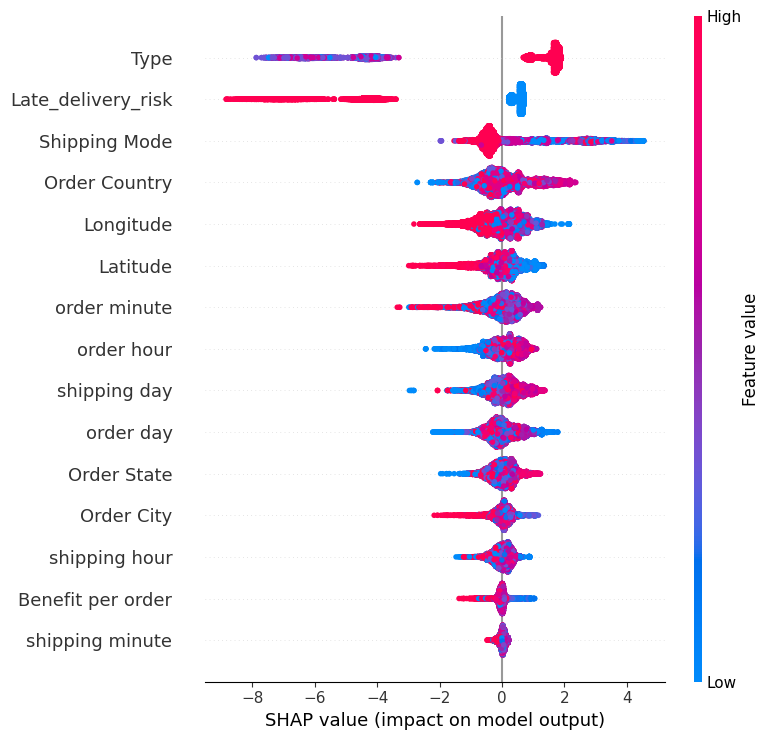

In [31]:
import shap

# Load JS visualization code to notebook
shap.initjs()

# retrieve model parameters
# best_xgb_model = grid_xgb.best_estimator_

# Explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_resampled_sel)

shap.summary_plot(shap_values, X_resampled_sel)

In [32]:
# Load JS visualization code to the notebook
shap.initjs()

# Find indices where the label is 1
indices_label_1 = [i for i, label in enumerate(y_resampled) if label == 1]

instance_index = indices_label_1[0]  # Adjust this index to plot other instances
shap.force_plot(explainer.expected_value, shap_values.values[instance_index], feature_names=X_resampled_sel.columns)

In [33]:
indices_label_0 = [i for i, label in enumerate(y_resampled) if label == 0]

instance_index = indices_label_0[0]  # Adjust this index to plot other instances
shap.force_plot(explainer.expected_value, shap_values.values[instance_index], feature_names=X_resampled_sel.columns)

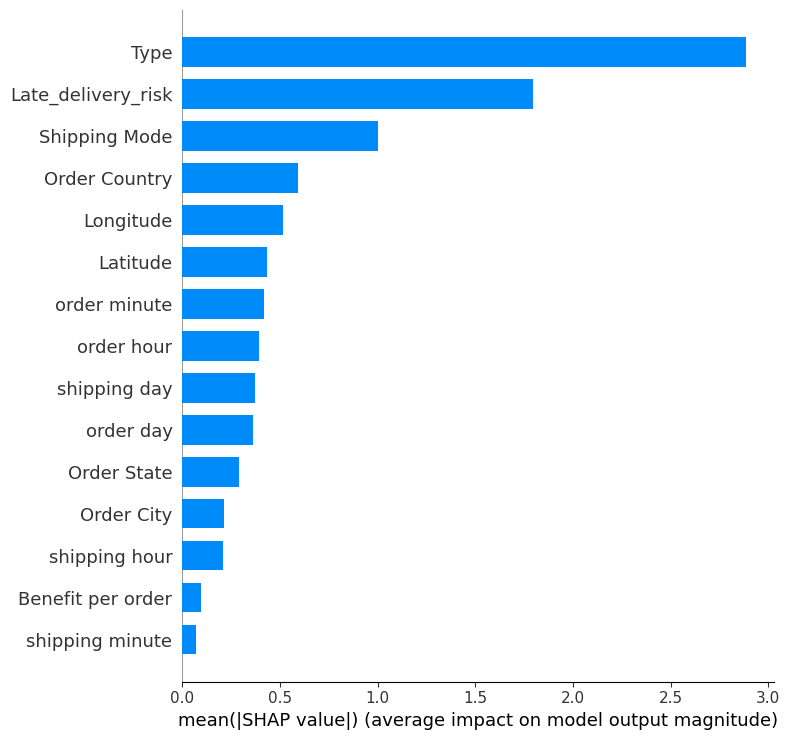

In [34]:
# Generate the summary plot
shap.summary_plot(shap_values, X_resampled_sel, plot_type="bar")
